<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [198]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.import_data_binance import (get_data_binance, rename_columns_symbol, add_symbols_indicators_to_df, 
                                        import_BVOL, add_bvol_index)

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, trx_plot
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import warnings
warnings.filterwarnings('ignore')


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2017-11-09'

In [4]:
# from config.py TRAIN_END_DATE is a string
config.TRAIN_END_DATE

'2021-04-30'

In [5]:
config.TEST_END_DATE

'2022-04-30'

In [3]:
TICKER_TO_TRADE = 'ETHUSDT'
CRYPTO_TICKERS = ['BTCUSDT']
#CRYPTO_TICKER = ['ETH-USD', 'BTC-USD']
#GLOBAL_TICKER = ['^STOXX50E', '^GSPC']

#TOTAL_TICKER = CRYPTO_TICKER + GLOBAL_TICKER



In [4]:
# Init Interval, starting and ending dates :

interval = '4h'
start_date = '2017-11-09'
end_date = '2022-04-30'

In [5]:
df = get_data_binance(symbol = TICKER_TO_TRADE, interval = '4h',
                            start_date = '2020-04-23', end_date = '2022-04-30')

In [6]:
df = add_symbols_indicators_to_df(df, CRYPTO_TICKERS, interval, start_date, end_date)

In [10]:
df = add_bvol_index(df, start_date, end_date)

We have one more value for BTC (it starts one day before) we will delete it.
For the global ticker we don't have the values on the week-end days so we will interpolate these values.
There is many ways to interpolate these values, we will start by taking the values of Friday for Saturday and the values of Monday for Sunday

In [186]:
# For now, we only start with crypto data so we don't have to do the interpolation
# We just drop the first row of the df

#df = df.drop([0])

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

## STILL NEED TO ADD FE ON THE NEW TICKERS

config.STOCK_INDICATORS

In [27]:
df_indicators.head()

,date,open,high,low,close,volume,tic,day,open_BTC-USD,high_BTC-USD,...,open_USDT-USD,high_USDT-USD,low_USDT-USD,close_USDT-USD,volume_USDT-USD,open_BNB-USD,high_BNB-USD,low_BNB-USD,close_BNB-USD,volume_BNB-USD
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,ETH-USD,3,7446.830078,7446.830078,...,1.01087,1.01327,0.996515,1.00818,358188000,2.05314,2.17423,1.89394,1.99077,19192200
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,ETH-USD,4,7173.729980,7312.000000,...,1.00650,1.02423,0.995486,1.00601,756446016,2.00773,2.06947,1.64478,1.79684,11155000
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992,ETH-USD,5,6618.609863,6873.149902,...,1.00598,1.02621,0.995799,1.00899,746227968,1.78628,1.91775,1.61429,1.67047,8178150
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936,ETH-USD,6,6295.450195,6625.049805,...,1.00602,1.10591,0.967601,1.01247,1466060032,1.66889,1.67280,1.46256,1.51969,15298700
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,ETH-USD,0,5938.250000,6811.189941,...,1.00448,1.02929,0.975103,1.00935,767884032,1.52601,1.73502,1.51760,1.68662,12238800


In [11]:
df['date'] = df['date_close_time']
df = df.drop(columns = ['date_close_time'])

for col in df.drop(columns = ['date', 'tic']):
    df = df.astype({col : float})

In [12]:
df

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,tic,...,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_qav,BTCUSDT_num_trades,BTCUSDT_taker_base_vol,BTCUSDT_taker_quote_vol,BVOL_avg,date
0,182.70,187.03,181.40,182.43,208220.00153,3.841226e+07,53401.0,97772.32407,1.803224e+07,ETHUSDT,...,7183.00,7100.00,7113.27,8483.468836,6.057426e+07,93970.0,4268.981451,3.048725e+07,6106.951460,2020-04-23 05:59:59.999
1,182.42,183.56,178.16,179.93,190135.74072,3.435644e+07,49896.0,87371.20146,1.578884e+07,ETHUSDT,...,7138.00,7020.00,7061.54,11068.025632,7.831504e+07,105501.0,5035.386906,3.562890e+07,6106.951460,2020-04-23 09:59:59.999
2,179.90,184.17,179.02,183.57,148497.83657,2.697481e+07,39822.0,74208.54503,1.348405e+07,ETHUSDT,...,7144.00,7046.21,7133.39,9010.849915,6.387758e+07,91764.0,4682.807951,3.320586e+07,6106.951460,2020-04-23 13:59:59.999
3,183.56,193.63,183.00,189.25,558065.09082,1.047557e+08,123943.0,296706.90120,5.569903e+07,ETHUSDT,...,7738.00,7108.23,7530.10,47597.905346,3.531331e+08,341474.0,26087.579239,1.933112e+08,6106.951460,2020-04-23 17:59:59.999
4,189.23,190.80,186.75,189.22,170614.33478,3.219671e+07,47226.0,80543.54747,1.520153e+07,ETHUSDT,...,7600.00,7485.00,7522.01,14458.890777,1.089188e+08,136540.0,6896.039189,5.195505e+07,6106.951460,2020-04-23 21:59:59.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4415,2925.84,2927.79,2834.28,2843.11,83541.11430,2.403387e+08,122219.0,37699.88750,1.084459e+08,ETHUSDT,...,39634.12,38616.46,38749.54,9182.311880,3.586849e+08,220175.0,4154.194220,1.622637e+08,417.580319,2022-04-29 13:59:59.999
4416,2843.11,2886.23,2832.07,2856.51,117031.42800,3.347771e+08,139054.0,60742.09230,1.737381e+08,ETHUSDT,...,39406.37,38634.52,39004.86,13776.465970,5.375388e+08,261194.0,7022.475110,2.740444e+08,417.580319,2022-04-29 17:59:59.999
4417,2856.51,2857.53,2776.63,2792.96,149203.89780,4.197946e+08,166096.0,65577.47930,1.845992e+08,ETHUSDT,...,39078.30,38175.00,38331.54,13577.880450,5.237720e+08,210977.0,6227.874820,2.402407e+08,417.580319,2022-04-29 21:59:59.999
4418,2792.95,2823.17,2789.07,2817.13,54514.02340,1.530561e+08,74339.0,27757.87580,7.793287e+07,ETHUSDT,...,38665.36,38310.90,38596.11,4115.384430,1.585375e+08,110420.0,1993.657320,7.679313e+07,404.569438,2022-04-30 01:59:59.999


In [13]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature = False)

#processed = fe.preprocess_data(df)
processed = fe.preprocess_data(df)

Successfully added technical indicators


In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

#processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
#processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

# Change 'date' to index of the df

#processed_full = processed_full.set_index('date')

In [15]:
processed_full.sort_values(['date','tic'],ignore_index=False).head()

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,tic,...,BVOL_avg,date,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,182.70,187.03,181.40,182.43,208220.00153,3.841226e+07,53401.0,97772.32407,1.803224e+07,ETHUSDT,...,6106.95146,2020-04-23 05:59:59.999,0.000000,184.715534,177.644466,0.000000,-66.666667,100.000000,182.430000,182.430000
1,182.42,183.56,178.16,179.93,190135.74072,3.435644e+07,49896.0,87371.20146,1.578884e+07,ETHUSDT,...,6106.95146,2020-04-23 09:59:59.999,-0.056090,184.715534,177.644466,0.000000,-66.666667,100.000000,181.180000,181.180000
2,179.90,184.17,179.02,183.57,148497.83657,2.697481e+07,39822.0,74208.54503,1.348405e+07,ETHUSDT,...,6106.95146,2020-04-23 13:59:59.999,0.041407,185.700392,178.252941,60.099064,7.053073,66.492425,181.976667,181.976667
3,183.56,193.63,183.00,189.25,558065.09082,1.047557e+08,123943.0,296706.90120,5.569903e+07,ETHUSDT,...,6106.95146,2020-04-23 17:59:59.999,0.289809,191.678240,175.911760,79.747238,133.333333,55.924036,183.795000,183.795000
4,189.23,190.80,186.75,189.22,170614.33478,3.219671e+07,47226.0,80543.54747,1.520153e+07,ETHUSDT,...,6106.95146,2020-04-23 21:59:59.999,0.417493,193.255775,176.504225,79.533252,86.438880,55.924036,184.880000,184.880000


In [16]:
processed_full.columns

Index(['open', 'high', 'low', 'close', 'volume', 'qav', 'num_trades',
       'taker_base_vol', 'taker_quote_vol', 'tic', 'BTCUSDT_open',
       'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close', 'BTCUSDT_volume',
       'BTCUSDT_qav', 'BTCUSDT_num_trades', 'BTCUSDT_taker_base_vol',
       'BTCUSDT_taker_quote_vol', 'BVOL_avg', 'date', 'macd', 'boll_ub',
       'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'],
      dtype='object')

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

To apply this environment to the trade only on the Ethereum crypto, we will allow to trade only on 'ETH-USD

## Training data split: 2017-11-09 to 2021-04-30
## Trade data split: 2021-04-30 to 2022-04-30

In [21]:
train = data_split(processed_full, '2021-01-01','2022-01-31')
trade = data_split(processed_full, '2022-02-01','2022-04-30')
print(len(train))
print(len(trade))

2368
528


In [22]:
train.tail()

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,tic,...,BVOL_avg,date,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
2363,2601.43,2614.97,2563.49,2570.48,44801.7225,1.157153e+08,86486.0,21628.7040,5.585452e+07,ETHUSDT,...,602.287072,2022-01-30 04:59:59.999,23.374725,2633.031623,2331.022377,48.697810,107.530537,20.052778,2481.874667,2548.085000
2364,2570.48,2632.40,2568.00,2618.89,52402.5198,1.363172e+08,86382.0,30350.2037,7.892724e+07,ETHUSDT,...,602.287072,2022-01-30 08:59:59.999,28.325286,2652.345012,2327.298988,50.585264,119.772969,22.629579,2489.726000,2539.418000
2365,2618.89,2640.00,2597.30,2626.24,35595.5459,9.309629e+07,78896.0,17393.1867,4.550832e+07,ETHUSDT,...,602.287072,2022-01-30 12:59:59.999,32.467460,2665.142007,2340.638993,50.869167,122.262814,23.774713,2496.456333,2530.657667
2366,2626.24,2639.00,2585.58,2617.20,44431.9267,1.159777e+08,93139.0,22463.1038,5.865013e+07,ETHUSDT,...,602.287072,2022-01-30 16:59:59.999,34.621614,2676.438745,2350.684255,50.500011,106.089758,20.826748,2503.051667,2519.920667
2367,2617.19,2624.66,2552.95,2560.25,42945.5536,1.112929e+08,93113.0,21255.9830,5.510085e+07,ETHUSDT,...,602.287072,2022-01-30 20:59:59.999,31.371774,2680.584476,2356.897524,48.219531,68.549775,12.829060,2506.184000,2509.003500


In [23]:
trade.head()

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,tic,...,BVOL_avg,date,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2672.50,2705.84,2662.51,2686.94,53397.38210,1.432612e+08,99279.0,29977.30170,8.043519e+07,ETHUSDT,...,575.951513,2022-02-01 00:59:59.999,34.953188,2686.328610,2471.669390,53.422845,143.803070,27.128142,2526.042667,2483.514500
1,2686.94,2757.90,2673.52,2751.62,68492.66632,1.858136e+08,141785.0,38680.89202,1.049474e+08,ETHUSDT,...,575.951513,2022-02-01 04:59:59.999,44.479060,2711.872524,2475.113476,55.757061,170.453717,34.153878,2538.934333,2486.587167
2,2751.63,2767.31,2718.22,2736.69,45243.85150,1.239928e+08,88258.0,21320.05110,5.842782e+07,ETHUSDT,...,575.951513,2022-02-01 08:59:59.999,50.244470,2735.170890,2470.985110,55.097713,172.399304,35.358069,2550.031333,2491.130333
3,2736.69,2796.79,2719.00,2761.32,82354.48390,2.267783e+08,150421.0,39729.48730,1.094067e+08,ETHUSDT,...,575.951513,2022-02-01 12:59:59.999,56.153729,2760.400744,2467.739256,55.985961,175.056878,39.088558,2560.186667,2496.634500
4,2761.31,2811.26,2732.05,2768.54,99189.54140,2.752040e+08,196344.0,50160.31390,1.392243e+08,ETHUSDT,...,575.951513,2022-02-01 16:59:59.999,60.719515,2783.988940,2464.211060,56.248416,166.970717,40.878751,2569.810000,2502.993500


In [76]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + (len(train.columns) - 2)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 30


In [77]:
trade.columns

Index(['open', 'high', 'low', 'close', 'volume', 'qav', 'num_trades',
       'taker_base_vol', 'taker_quote_vol', 'tic', 'BTCUSDT_open',
       'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close', 'BTCUSDT_volume',
       'BTCUSDT_qav', 'BTCUSDT_num_trades', 'BTCUSDT_taker_base_vol',
       'BTCUSDT_taker_quote_vol', 'BVOL_avg', 'date', 'macd', 'boll_ub',
       'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'],
      dtype='object')

In [85]:
num_stock_shares

[0]

In [113]:
# CARE, HERE I MODIFIED 0.001 to 0 to annualate trade fees for our model to trade more

buy_cost_list = sell_cost_list = 0
num_stock_shares = stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
#    "tech_indicator_list": config.INDICATORS,
    "tech_indicator_list" : ['open', 'high', 'low', 'close', 'volume', 'qav', 'num_trades',
       'taker_base_vol', 'taker_quote_vol', 'BTCUSDT_open',
       'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close', 'BTCUSDT_volume',
       'BTCUSDT_qav', 'BTCUSDT_num_trades', 'BTCUSDT_taker_base_vol',
       'BTCUSDT_taker_quote_vol', 'macd', 'boll_ub', 'boll_lb',
       'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'BVOL_avg'],
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = MyStockTradingEnv(df = train, **env_kwargs)

In [79]:
e_train_gym.state

# each state contains the values of all variables, the account balance, and the number of stock we buy or sell 
# and two times the close value

[1000000,
 736.42,
 0,
 738.76,
 745.0,
 731.83,
 736.42,
 64016.27221,
 47337589.5091425,
 70903.0,
 33613.96272,
 24860568.3274434,
 28897.84,
 29169.55,
 28780.0,
 28923.63,
 7875.879035,
 228504927.44326457,
 175976.0,
 3691.598479,
 107107628.00888008,
 16.436989835801114,
 760.5080699046682,
 707.3679300953315,
 58.852816483599604,
 57.44164782487306,
 3.8751765412125847,
 719.9313333333334,
 666.4311666666666,
 1561.5997578229026]

## Environment for Training



In [114]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [214]:
##### CHANGES ADDED TO STOCKTRADINGENV :
##### - change cost percetage of trades


import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
from typing import List
matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat


class MyStockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        hmax: int,
        initial_amount: int,
        num_stock_shares: int,   # Later change it for a float
        buy_cost_pct: int,
        sell_cost_pct: int,
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: List[str],
        risk_indicator_col="BVOL_avg",
        make_plots: bool =False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.hmax = hmax
        self.num_stock_shares=num_stock_shares
        self.initial_amount = initial_amount # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount+np.sum(np.array(self.num_stock_shares)*np.array(self.state[1]))] # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory=[] # we need sometimes to preserve the state in the middle of trading process 
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, action):
        def _do_sell_normal():
            #if self.state[1]!=True : # check if the stock is able to sell, for simlicity we just add it in techical index
            # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                
            
                #### MIGHT WANT TO CHANGE THIS CONDITION : self.state[1]!=True
                
            if self.state[1] > 0:
                # Sell only if current asset is > 0
                sell_num_shares = min(
                    abs(action), self.state[2]       # min bc we can't sell more than we have
                )
                sell_amount = (
                    self.state[1]
                    * sell_num_shares
                    * (1 - self.sell_cost_pct)
                )
                # update balance
                self.state[0] += sell_amount

                self.state[2] -= sell_num_shares
                self.cost += (
                    self.state[1] * sell_num_shares * self.sell_cost_pct
                )
                self.trades += 1
            else:
                sell_num_shares = 0

            return sell_num_shares
        
        sell_num_shares = _do_sell_normal()

        return sell_num_shares

    
    
    def _buy_stock(self, action):
        def _do_buy():
            #if self.state[3] !=True: # check if the stock is able to buy
            if self.state[1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] / (self.state[1]*(1 + self.buy_cost_pct)) # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[2] += buy_num_shares

                self.cost += self.state[1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0
            return buy_num_shares

        buy_num_shares = _do_buy()
        return buy_num_shares

    
    
    
    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

        
        
        
    def step(self, action):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + self.state[1] * self.state[2]
                
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                    end_total_asset
                    - self.asset_memory[0]
                    ) # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                
                print(tot_reward)
                
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}
        
        
        
        
        # WORKING ON ACTION, IN WHAT FORM DO WE HAVE OUR ACTION ?
        
        
        
        

        else:
            action = action * self.hmax  # action initially is scaled between 0 to 1
            action = int(action) # convert into integer because we can't by fraction of shares
            #### To change later when we will add float for number of shares we buy
            
            #if self.turbulence_threshold is not None:
            #    if self.turbulence >= self.turbulence_threshold:
            #        actions = np.array([-self.hmax] * self.stock_dim)
                
            begin_total_asset = self.state[0] + self.state[1] * self.state[2]
            
            # print("begin_total_asset:{}".format(begin_total_asset))

            if(action < 0):
                action = self._sell_stock(action) * (-1)
            else:
                action = self._buy_stock(action)

            self.actions_memory.append(action)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            self.state = self._update_state()

            end_total_asset = self.state[0] + np.array(self.state[1]) * (self.state[2])
            
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(self.state) # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount+ (self.num_stock_shares)*(self.state[2])]
        else:
            previous_total_asset = self.previous_state[0] + self.state[1] * self.state[2]
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            # for single stock
            state = (
                [self.initial_amount]
                + [self.data.close]
                + [0]
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            # for single stock
            state = (
                [self.previous_state[0]]
                + [self.data.close]
                + self.previous_state[2]
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _update_state(self):

        # for single stock
        state = (
            [self.state[0]]
            + [self.data.close]
            + [self.state[2]]
            + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
        )

        return state

    def _get_date(self):
        date = self.data.date
        return date

    
    # add save_state_memory to preserve state in the trading process 
    def save_state_memory(self):
        
        date_list = self.date_memory[:-1]
        state_list = self.state_memory
        df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    
    def save_action_memory(self):
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    
    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    

e_train_gym = MyStockTradingEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))


<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [144]:
e_train_gym._initiate_state()

[1000000,
 736.42,
 0,
 738.76,
 745.0,
 731.83,
 736.42,
 64016.27221,
 47337589.5091425,
 70903.0,
 33613.96272,
 24860568.3274434,
 28897.84,
 29169.55,
 28780.0,
 28923.63,
 7875.879035,
 228504927.44326457,
 175976.0,
 3691.598479,
 107107628.00888008,
 16.436989835801114,
 760.5080699046682,
 707.3679300953315,
 58.852816483599604,
 57.44164782487306,
 3.8751765412125847,
 719.9313333333334,
 666.4311666666666,
 1561.5997578229026]

In [133]:
e_train_gym._buy_stock(10)

10

In [154]:
e_train_gym.step(-20)

action : -2000


([1000811.2,
  738.85,
  0,
  737.37,
  741.76,
  725.1,
  738.85,
  128108.21447,
  94014242.5380369,
  97917.0,
  62143.49657,
  45617214.7026484,
  29092.84,
  29402.57,
  28872.24,
  29313.49,
  8283.705319,
  241843536.24794328,
  195352.0,
  4554.094883,
  132989690.4973169,
  13.520495494451211,
  757.448058952107,
  715.079941047893,
  58.71019220140034,
  40.56452195111373,
  1.6638821237973758,
  729.5636666666667,
  673.1593333333333,
  1561.5997578229026],
 0.0,
 False,
 {})

In [128]:
e_train_gym._buy_stock()

[1000000,
 3937.76,
 0,
 3870.09,
 3983.65,
 3819.99,
 3937.76,
 198177.02677,
 775898738.6131685,
 409224.0,
 101827.45785,
 398688022.2051007,
 58635.72,
 58974.91,
 57575.0,
 57965.59,
 16054.303408,
 935047521.0020086,
 475419.0,
 7752.358897,
 451731330.6974453,
 151.18190206395002,
 3908.53049007806,
 3248.5305099219413,
 67.92606121927085,
 237.2478428618676,
 54.429806450234786,
 3507.684,
 3224.379333333333,
 698.9370599034308]

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [215]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [223]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

------------------------------------
| time/                 |          |
|    fps                | 321      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | -0.439   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.897    |
|    reward             | 0.7844   |
|    std                | 0.994    |
|    value_loss         | 0.46     |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 357        |
|    iterations         | 200        |
|    time_elapsed       | 2          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -1.42      |
|    explained_variance | -0.0917    |
|    learning_rate      | 0.0007     |
|    n_updates    

---------------------------------------
| time/                 |             |
|    fps                | 376         |
|    iterations         | 1500        |
|    time_elapsed       | 19          |
|    total_timesteps    | 7500        |
| train/                |             |
|    entropy_loss       | -1.43       |
|    explained_variance | 0.0226      |
|    learning_rate      | 0.0007      |
|    n_updates          | 1499        |
|    policy_loss        | 14.8        |
|    reward             | -0.24555874 |
|    std                | 1.01        |
|    value_loss         | 71.2        |
---------------------------------------


### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             #total_timesteps=50000)
                             total_timesteps=10000)

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             #total_timesteps=60000)
                             total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [34]:
data_risk_indicator = processed_full[(processed_full.date<'2022-01-31') & (processed_full.date>='2021-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [35]:
insample_risk_indicator.BVOL_avg.describe()

count    2368.000000
mean      965.025537
std       466.247648
min       521.224205
25%       668.113540
50%       790.737297
75%      1037.635146
max      2476.287924
Name: BVOL_avg, dtype: float64

In [36]:
insample_risk_indicator.BVOL_avg.quantile(0.996)

2475.8583292766675

In [37]:
insample_risk_indicator.turbulence.describe()

AttributeError: 'DataFrame' object has no attribute 'turbulence'

In [61]:
insample_risk_indicator.turbulence.quantile(0.996)

12.651610411007068

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [158]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
#e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
e_trade_gym = MyStockTradingEnv(df = trade, risk_indicator_col='BVOL_avg', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [119]:
trade.head()

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,tic,...,BVOL_avg,date,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2672.50,2705.84,2662.51,2686.94,53397.38210,1.432612e+08,99279.0,29977.30170,8.043519e+07,ETHUSDT,...,575.951513,2022-02-01 00:59:59.999,34.953188,2686.328610,2471.669390,53.422845,143.803070,27.128142,2526.042667,2483.514500
1,2686.94,2757.90,2673.52,2751.62,68492.66632,1.858136e+08,141785.0,38680.89202,1.049474e+08,ETHUSDT,...,575.951513,2022-02-01 04:59:59.999,44.479060,2711.872524,2475.113476,55.757061,170.453717,34.153878,2538.934333,2486.587167
2,2751.63,2767.31,2718.22,2736.69,45243.85150,1.239928e+08,88258.0,21320.05110,5.842782e+07,ETHUSDT,...,575.951513,2022-02-01 08:59:59.999,50.244470,2735.170890,2470.985110,55.097713,172.399304,35.358069,2550.031333,2491.130333
3,2736.69,2796.79,2719.00,2761.32,82354.48390,2.267783e+08,150421.0,39729.48730,1.094067e+08,ETHUSDT,...,575.951513,2022-02-01 12:59:59.999,56.153729,2760.400744,2467.739256,55.985961,175.056878,39.088558,2560.186667,2496.634500
4,2761.31,2811.26,2732.05,2768.54,99189.54140,2.752040e+08,196344.0,50160.31390,1.392243e+08,ETHUSDT,...,575.951513,2022-02-01 16:59:59.999,60.719515,2783.988940,2464.211060,56.248416,166.970717,40.878751,2569.810000,2502.993500


# Model results

In [ ]:
df_account_value = []
df_actions = []

models = [trained_a2c, trained_ddpg, trained_ppo, trained_td3, trained_sac]

pct_mvment_eth = (trade['close'].iloc[len(trade)-1] - trade['close'].iloc[0])/trade['close'].iloc[0]
print(f' eth has increased from {round(pct_mvment_eth*100, 2)}% between the start and the end of the trading period')

for current_model in models:
    current_df_account_value, current_df_actions = DRLAgent.DRL_prediction(
    model=current_model, 
    environment = e_trade_gym)
    pct_mvment_portfolio = ((current_df_account_value['account_value'].iloc[len(current_df_account_value)-1] 
                            - current_df_account_value['account_value'].iloc[0])
                            / current_df_account_value['account_value'].iloc[0])
    print(f' Our RL trader has increased our balance from {round(pct_mvment_portfolio*100, 2)}% between the start and the end of the trading period')
    
    df_account_value.append(current_df_account_value)
    df_actions.append(current_df_actions)
    
    
    

In [221]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100
action : 100

In [222]:
df_account_value_sac

,date,account_value
0,2022-02-01 00:59:59.999,1.000000e+06
1,2022-02-01 04:59:59.999,1.006468e+06
2,2022-02-01 08:59:59.999,1.003482e+06
3,2022-02-01 12:59:59.999,1.010871e+06
4,2022-02-01 16:59:59.999,1.013514e+06
...,...,...
523,2022-04-29 05:59:59.999,1.071234e+06
524,2022-04-29 09:59:59.999,1.071103e+06
525,2022-04-29 13:59:59.999,1.040813e+06
526,2022-04-29 17:59:59.999,1.045718e+06


In [159]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

action : -42
action : -31
action : -42
action : 7
action : -16
action : 11
action : -10
action : -42
action : -10
action : 11
action : -42
action : -33
action : -42
action : -42
action : -22
action : -22
action : -42
action : -22
action : -33
action : 5
action : -36
action : -31
action : 7
action : 14
action : 14
action : 0
action : -42
action : -8
action : -13
action : -26
action : -10
action : -22
action : -42
action : -42
action : -22
action : -27
action : 11
action : 5
action : -42
action : -10
action : 14
action : 11
action : -10
action : -10
action : 11
action : 19
action : 14
action : 14
action : 14
action : -3
action : -8
action : -33
action : -33
action : -24
action : -33
action : -16
action : -42
action : -33
action : 11
action : 5
action : 1
action : 14
action : -42
action : -10
action : -10
action : -10
action : -42
action : -42
action : -16
action : -36
action : -42
action : -10
action : -42
action : -27
action : -33
action : -16
action : -42
action : -42
action : -39
acti

In [180]:
pct_mvment_eth = (trade['close'].iloc[len(trade)-1] - trade['close'].iloc[0])/trade['close'].iloc[0]
print(f' eth has increased from {round(pct_mvment_eth*100, 2)}% between the start and the end of the trading period')

 eth has increased from 3.95% between the start and the end of the trading period


In [195]:
pct_mvment_portfolio = (df_account_value['account_value'].iloc[len(df_account_value)-1] - df_account_value['account_value'].iloc[0])/df_account_value['account_value'].iloc[0]
print(f' Our RL trader has increased our balance from {round(pct_mvment_portfolio*100, 2)}% between the start and the end of the trading period')

 Our RL trader has increased our balance from 9.87% between the start and the end of the trading period


In [193]:
import matplotlib.pyplot as plt

x = np.array([1, 3, 4, 6])
y = np.array([2, 3, 5, 1])
plt.plot(x, y)

plt.show() # affiche la figure a l'ecran

In [192]:
import matplotlib.pyplot as plt

plt.plot(df_account_value['date'], df_account_value['account_value'])


In [169]:
plt.plot(trade['close'])

In [161]:
df_actions

,date,actions
0,2022-02-01 00:59:59.999,0.0
1,2022-02-01 04:59:59.999,0.0
2,2022-02-01 08:59:59.999,0.0
3,2022-02-01 12:59:59.999,7.0
4,2022-02-01 16:59:59.999,-7.0
...,...,...
522,2022-04-29 01:59:59.999,-1.0
523,2022-04-29 05:59:59.999,-0.0
524,2022-04-29 09:59:59.999,-0.0
525,2022-04-29 13:59:59.999,-0.0


In [122]:
test_obs

array([[ 1.0000000e+06,  2.7929600e+03,  0.0000000e+00,  2.8565100e+03,
         2.8575300e+03,  2.7766299e+03,  2.7929600e+03,  1.4920389e+05,
         4.1979459e+08,  1.6609600e+05,  6.5577477e+04,  1.8459918e+08,
         3.9004871e+04,  3.9078301e+04,  3.8175000e+04,  3.8331539e+04,
         1.3577881e+04,  5.2377197e+08,  2.1097700e+05,  6.2278750e+03,
         2.4024074e+08, -1.9316422e+01,  2.9632217e+03,  2.7927622e+03,
         4.1322777e+01, -1.3007437e+02,  3.7766422e+01,  2.8975154e+03,
         2.9567004e+03,  4.1758032e+02]], dtype=float32)

In [52]:
account_memory

[                        date  account_value
 0    2022-02-01 00:59:59.999     1000000.00
 1    2022-02-01 04:59:59.999     1001746.36
 2    2022-02-01 08:59:59.999     1001746.36
 3    2022-02-01 12:59:59.999     1001746.36
 4    2022-02-01 16:59:59.999     1001746.36
 ..                       ...            ...
 523  2022-04-29 05:59:59.999     1001746.36
 524  2022-04-29 09:59:59.999     1001746.36
 525  2022-04-29 13:59:59.999     1001746.36
 526  2022-04-29 17:59:59.999     1001746.36
 527  2022-04-29 21:59:59.999     1001746.36
 
 [528 rows x 2 columns]]

In [54]:
27 * (trade['close'].iloc[1] - trade['close'].iloc[0])

1746.3599999999956

In [57]:
trade['close'].iloc[len(trade) - 1] - trade['close'].iloc[0]

106.01999999999998

In [124]:
### DRL_prediction

environment = e_trade_gym
test_env, test_obs = e_trade_gym.get_sb_env()
model = trained_ppo

account_memory = []
actions_memory = []

test_env.reset()
for i in range(len(environment.df.index.unique())):
    action, _states = model.predict(test_obs, deterministic=True)
    #print(action)
    #print(_states)
    # account_memory = test_env.env_method(method_name="save_asset_memory")
    # actions_memory = test_env.env_method(method_name="save_action_memory")
    test_obs, rewards, dones, info = test_env.step(action)
    print(rewards)
    if i == (len(environment.df.index.unique()) - 2):
        account_memory = test_env.env_method(method_name="save_asset_memory")
        actions_memory = test_env.env_method(method_name="save_action_memory")
#                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
    if dones[0]:
        print("hit end!")
        break


[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [59]:
e_trade_gym.df.index.unique()

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            164, 165, 166, 167, 168, 169, 170, 171, 172, 173],
           dtype='int64', length=174)

In [52]:
df_account_value.shape

(174, 2)

In [41]:
df_account_value.tail()

,date,account_value
523,2022-04-29 05:59:59.999,1001746.36
524,2022-04-29 09:59:59.999,1001746.36
525,2022-04-29 13:59:59.999,1001746.36
526,2022-04-29 17:59:59.999,1001746.36
527,2022-04-29 21:59:59.999,1001746.36


In [42]:
df_actions.head()

,date,actions
0,2022-02-01 00:59:59.999,[27]
1,2022-02-01 04:59:59.999,[-27]
2,2022-02-01 08:59:59.999,[0]
3,2022-02-01 12:59:59.999,[0]
4,2022-02-01 16:59:59.999,[0]


In [164]:
for i in range(len(df_actions['actions'])):
    print(df_actions['actions'].iloc[i])

0.0
0.0
0.0
7.0
-7.0
11.0
-10.0
-1.0
0.0
11.0
-11.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.0
-5.0
0.0
7.0
14.0
14.0
0.0
-35.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
11.0
5.0
-16.0
0.0
14.0
11.0
-10.0
-10.0
11.0
19.0
14.0
14.0
14.0
-3.0
-8.0
-33.0
-33.0
0.0
0.0
0.0
0.0
0.0
11.0
5.0
1.0
14.0
-31.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
-10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
11.0
-1.0
7.0
-17.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.0
11.0
22.0
-10.0
-26.0
-4.0
0.0
0.0
19.0
-16.0
-3.0
0.0
11.0
14.0
0.0
-1.0
-10.0
-10.0
19.0
-8.0
14.0
-29.0
17.0
19.0
1.0
1.0
22.0
10.0
14.0
1.0
-16.0
17.0
14.0
5.0
19.0
10.0
14.0
14.0
-16.0
-8.0
11.0
11.0
-10.0
5.0
11.0
-1.0
-1.0
7.0
1.0
11.0
-8.0
11.0
14.0
19.0
19.0
19.0
11.0
13.0
10.0

In [104]:
print(sum(df_actions['actions']))

[290]


In [37]:
cost_buy = 0
gain_sell = 0
total_shares = 0

for i in range(len(trade)):
    if (df_actions['actions'].iloc[i] > 0):
        cost_buy += trade['close'].iloc[i]
    else:
        gain_sell += trade['close'].iloc[i]
    total_shares += df_actions['actions'].iloc[i]
    if(total_shares<0):
        print(i)
        print(total_shares)
        
print(f'During trading time, total cost : {cost_buy}, total gain : {gain_sell}, ETH shares : {total_shares}')

IndexError: single positional indexer is out-of-bounds

In [38]:
trade['open']

0      3283.55
1      3281.51
2      3250.29
3      3279.41
4      3284.96
        ...   
169    2936.92
170    2926.21
171    2925.84
172    2843.11
173    2856.51
Name: open, Length: 174, dtype: float64

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [197]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.045938
Cumulative returns     0.098676
Annual volatility      0.068888
Sharpe ratio           0.687576
Calmar ratio           0.652577
Stability              0.721963
Max drawdown          -0.070395
Omega ratio            1.297903
Sortino ratio          1.074959
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.646754
Daily value at risk   -0.008491
dtype: float64


In [163]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="ETH-USD", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/site-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/yfinance/multi.py", line 188, in _download_one_threaded
    data = _download_one(ticker, start, end, auto_adjust, back_adjust,
  File "/usr/local/lib/python3.9/site-packages/yfinance/multi.py", line 202, in _download_one
    return Ticker(ticker).history(period=period, interval=interval,
  File "/usr/local/lib/python3.9/site-packages/yfinance/base.py", line 153, in history
    _time.strptime(str(start), '%Y-%m-%d

==============Get Baseline Stats===========


KeyboardInterrupt: 

In [151]:
df_account_value.loc[0,'date']

'2021-04-30'

In [152]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-04-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

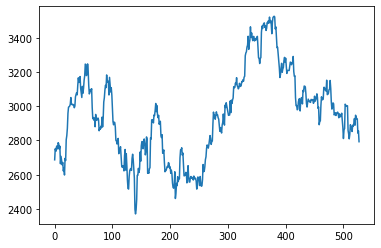

In [199]:
# Cours de l'ether

plt.plot(trade['close'])
plt.show()

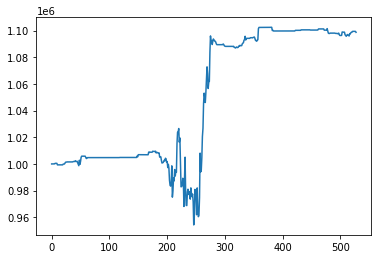

In [202]:
plt.plot(df_account_value['account_value'])
plt.show()

In [208]:
def trx_plot(df_trade, df_actions, ticker_list):
    df_trx = pd.DataFrame(np.array(df_actions["actions"].to_list()))
    df_trx.columns = ticker_list
    df_trx.index = df_actions["date"]
    df_trx.index.name = ""

    for i in range(df_trx.shape[1]):
        df_trx_temp = df_trx.iloc[:, i]
        df_trx_temp_sign = np.sign(df_trx_temp)
        buying_signal = df_trx_temp_sign.apply(lambda x: x > 0)
        selling_signal = df_trx_temp_sign.apply(lambda x: x < 0)

        tic_plot = df_trade[
            (df_trade["tic"] == df_trx_temp.name)
            & (df_trade["date"].isin(df_trx.index))
            ]["close"]
        tic_plot.index = df_trx_temp.index

        plt.figure(figsize=(10, 8))
        plt.plot(tic_plot, color="g", lw=2.0)
        plt.plot(
            tic_plot,
            "^",
            markersize=10,
            color="m",
            label="buying signal",
            markevery=buying_signal,
        )
        plt.plot(
            tic_plot,
            "v",
            markersize=10,
            color="k",
            label="selling signal",
            markevery=selling_signal,
        )
        plt.title(
            f"{df_trx_temp.name} Num Transactions: {len(buying_signal[buying_signal == True]) + len(selling_signal[selling_signal == True])}"
        )
        plt.legend()
        #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
        #plt.xticks(rotation=45, ha="right")
        plt.show()

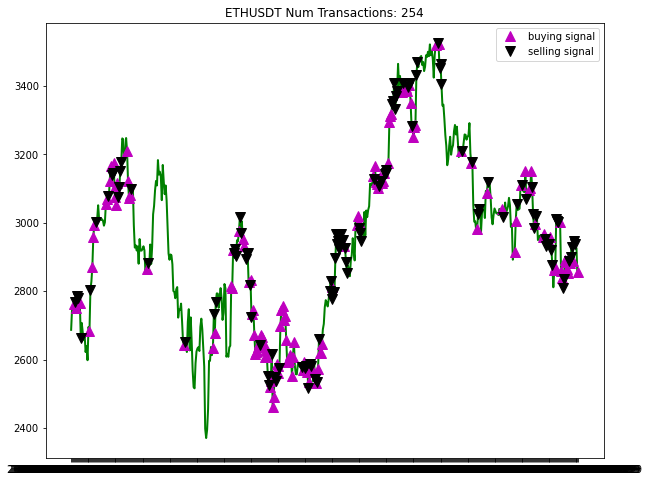

In [209]:
trx_plot(trade, df_actions, ['ETHUSDT'])

In [48]:
df_account_value['account_value']

0      1000000.00
1       999594.14
2       999594.14
3       999594.14
4       999594.14
          ...    
169     999594.14
170     999594.14
171     999594.14
172     999594.14
173     999594.14
Name: account_value, Length: 174, dtype: float64

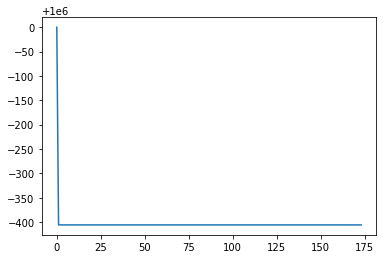

In [47]:
# Portfolio Value

plt.plot(df_account_value['account_value'])
plt.show()

In [41]:
print("==============Compare to ETH===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = 'ETH-USD', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to ETH===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30, 8)


Start date,2022-04-01
End date,2022-04-29
Total months,8
,Backtest
Annual return,-0.1%
Cumulative returns,-0.0%
Annual volatility,0.0%
Sharpe ratio,-1.21
Calmar ratio,-1.45
Stability,0.00
Max drawdown,-0.0%


IndexError: index -1 is out of bounds for axis 0 with size 0

In [74]:
e_train_gym.state

[1000000,
 736.42,
 0,
 738.76,
 745.0,
 731.83,
 736.42,
 64016.27221,
 47337589.5091425,
 70903.0,
 33613.96272,
 24860568.3274434,
 28897.84,
 29169.55,
 28780.0,
 28923.63,
 7875.879035,
 228504927.44326457,
 175976.0,
 3691.598479,
 107107628.00888008,
 16.436989835801114,
 760.5080699046682,
 707.3679300953315,
 58.852816483599604,
 57.44164782487306,
 3.8751765412125847,
 719.9313333333334,
 666.4311666666666,
 1561.5997578229026]

In [75]:
##### CHANGES ADDED TO STOCKTRADINGENV :
##### - change cost percetage of trades


import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
from typing import List
matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat


class MyStockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        hmax: int,
        initial_amount: int,
        num_stock_shares: int,   # Later change it for a float
        buy_cost_pct: int,
        sell_cost_pct: int,
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: List[str],
        risk_indicator_col="BVOL_avg",
        make_plots: bool =False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.hmax = hmax
        self.num_stock_shares=num_stock_shares
        self.initial_amount = initial_amount # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount+np.sum(np.array(self.num_stock_shares)*np.array(self.state[1]))] # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory=[] # we need sometimes to preserve the state in the middle of trading process 
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, action):
        def _do_sell_normal():
            #if self.state[1]!=True : # check if the stock is able to sell, for simlicity we just add it in techical index
            # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                
            
                #### MIGHT WANT TO CHANGE THIS CONDITION : self.state[1]!=True
                
            if self.state[1] > 0:
                # Sell only if current asset is > 0
                sell_num_shares = min(
                    abs(action), self.state[2]       # min bc we can't sell more than we have
                )
                sell_amount = (
                    self.state[1]
                    * sell_num_shares
                    * (1 - self.sell_cost_pct)
                )
                # update balance
                self.state[0] += sell_amount

                self.state[2] -= sell_num_shares
                self.cost += (
                    self.state[1] * sell_num_shares * self.sell_cost_pct
                )
                self.trades += 1
            else:
                sell_num_shares = 0
            print(f'action : {action}')
            print(f'sold {sell_num_shares} shares')
            return sell_num_shares
        print(f'action : {action}')
        print(f'sold {sell_num_shares} shares')
        sell_num_shares = _do_sell_normal()
        return sell_num_shares

    
    
    def _buy_stock(self, action):
        def _do_buy():
            #if self.state[3] !=True: # check if the stock is able to buy
            if self.state[2] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] / (self.state[1]*(1 + self.buy_cost_pct)) # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[2] += buy_num_shares

                self.cost += self.state[1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0
            print(f'action : {action}')
            print(f'bought {buy_num_shares} shares')
            return buy_num_shares

        buy_num_shares = _do_buy()
        print(f'action : {action}')
        print(f'bought {buy_num_shares} shares')
        return buy_num_shares

    
    
    
    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

        
        
        
    def step(self, action):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + self.state[1] * self.state[2]
                
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                    end_total_asset
                    - self.asset_memory[0]
                    ) # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}
        
        
        
        
        # WORKING ON ACTION, IN WHAT FORM DO WE HAVE OUR ACTION ?
        
        
        
        

        else:
            action = action * self.hmax  # action initially is scaled between 0 to 1
            action = action.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            
            #### To change later when we will add float for number of shares we buy
            
            #if self.turbulence_threshold is not None:
            #    if self.turbulence >= self.turbulence_threshold:
            #        actions = np.array([-self.hmax] * self.stock_dim)
                
            begin_total_asset = self.state[0] + self.state[1] * self.state[2]
            
            # print("begin_total_asset:{}".format(begin_total_asset))

            if(action < 0):
                action = self._sell_stock(action) * (-1)
            else:
                action = self._sell_stock(action)

            self.actions_memory.append(action)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            self.state = self._update_state()

            end_total_asset = self.state[0] + np.array(self.state[1]) * (self.state[2])
            
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(self.state) # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount+ (self.num_stock_shares)*(self.state[2])]
        else:
            previous_total_asset = self.previous_state[0] + self.state[1] * self.state[2]
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            # for single stock
            state = (
                [self.initial_amount]
                + [self.data.close]
                + [0]
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            # for single stock
            state = (
                [self.previous_state[0]]
                + [self.data.close]
                + self.previous_state[2]
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _update_state(self):

        # for single stock
        state = (
            [self.state[0]]
            + [self.data.close]
            + [self.state[2]]
            + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
        )

        return state

    def _get_date(self):
        date = self.data.date
        return date

    
    # add save_state_memory to preserve state in the trading process 
    def save_state_memory(self):
        
        date_list = self.date_memory[:-1]
        state_list = self.state_memory
        df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    
    def save_action_memory(self):
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    
    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
